# Trail Power - Power Study

This is a study that will use properties in the a Capella model to perform a study on the number of solar panels required to satisfy various a few usage scenarios.

Access the System Model that is in GitHUB folder with a python module "caplellambse" that can read and modify the SMW/Capella model content.

In [1]:
import capellambse

import ipywidgets as widgets
from IPython.core.display import HTML
import numpy as np
import pandas as pd 
from IPython.display import Markdown


resources = {
    "Trail_Power_for_Campgrounds": "Trail_Power_for_Campgrounds/Trail Power for Campgrounds",
}
path_to_model = "../Trail Power.aird"
model = capellambse.MelodyModel(path_to_model, resources=resources)

import capellambse_helper #local python module in same directory as notebook needs to be included after model object is created since it patches/extends capabilitits of the model 

Display a diagram from the capella module with parameters being accessed. Note that this diagram is not being pulled dynamically, due to the desire to see the parameters on the diagram. It is pulling a snapshot of a .jpg diagram.

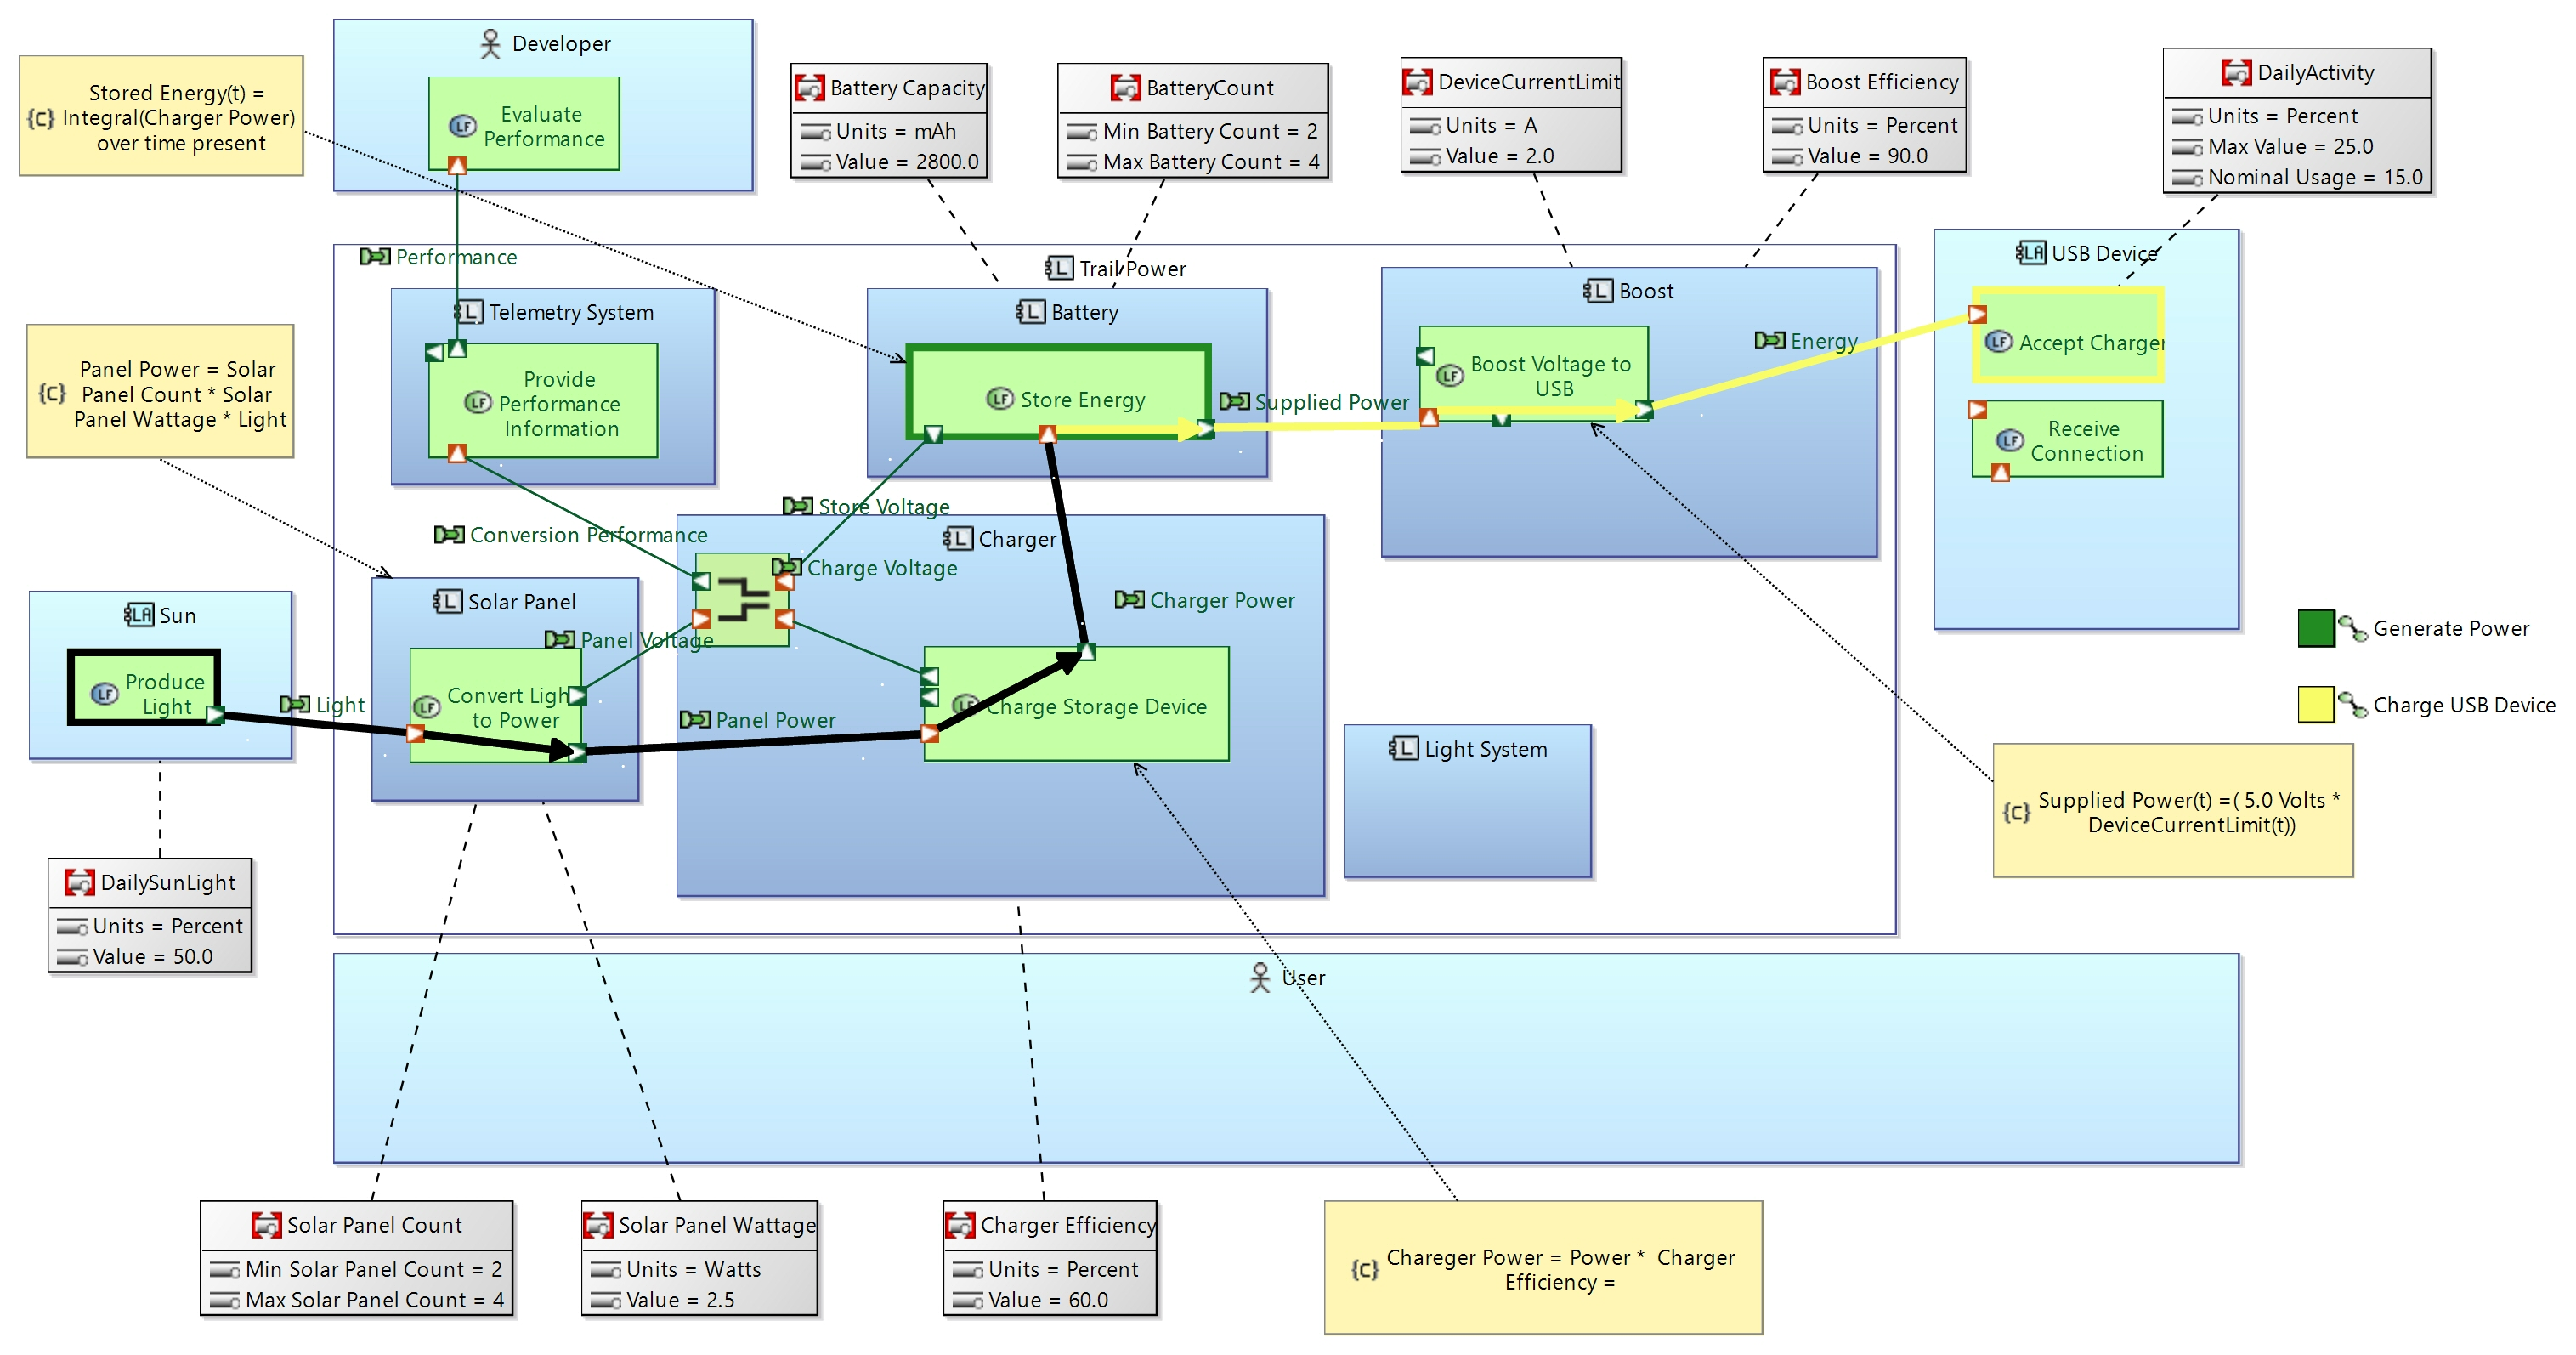

In [2]:
from IPython import display as diag_display
diag_display.Image("../Images/[LAB] Trail Power (Charge) Properties and Constraints.jpg")


## Display all the parameters and respective components/functions in the logical architecture
The following is a report of all the parameters avialable to be used. 

In [3]:
la_model = model.la 

capellambse_helper.display_function_property_values(la_model)

capellambse_helper.display_component_property_values(la_model)


Logical Function Property Value Group Name   Propery Name Property Value
0   Accept Charger             DailyActivity          Units        Percent
1   Accept Charger             DailyActivity      Max Value           25.0
2   Accept Charger             DailyActivity  Nominal Usage           15.0

Logical Component Property Value Group Name          Property Name  \
0              Boost          Boost Efficiency                  Units   
1              Boost          Boost Efficiency                  Value   
2              Boost        DeviceCurrentLimit                  Units   
3              Boost        DeviceCurrentLimit                  Value   
4            Battery          Battery Capacity                  Units   
5            Battery          Battery Capacity                  Value   
6            Battery              BatteryCount      Min Battery Count   
7            Battery              BatteryCount      Max Battery Count   
8        Solar Panel       Solar Panel Wattage                  Units   
9        Solar Panel       Solar Panel Wattage                  Value   
10       Solar Panel         Solar Panel Count  Min Solar Panel Count   
11       Solar Panel         Solar Panel Count  Max Solar Panel Count   
12           Charger        Charger Efficiency                  Units   
13           Charger        Charger Efficiency                  Value   
14               Sun             DailySunLight                  Units   
15               Sun             DailySunLight                  Value   

   Property Value  
0         Percent  
1            90.0  
2               A  
3             2.0  
4             mAh  
5          2800.0  
6               2  
7               4  
8           Watts  
9             2.5  
10              2  
11              4  
12        Percent  
13           60.0  
14        Percent  
15           50.0

## Display all the constraint components/functions in the logical architecture
The following is a report of all the constraints avialable to be used. 

The following code can be used in the study to retrive the value from the model to use in the study.

your_variable = model.search("LogicalFunction").by_name("Name of Function").property_value_groups["Name of property Value Group"]["Name of Property"])

You can see an example below.

In [12]:
print( "Battery Size" , model.search("LogicalComponent").by_name("Battery").property_value_groups["Battery Capacity"]["Value"] ,\
"Units:" ,model.search("LogicalComponent").by_name("Battery").property_value_groups["Battery Capacity"]["Units"])
help(model)

Battery Size 2800.0 Units: mAh
Help on MelodyModel in module capellambse.model._model object:

class MelodyModel(builtins.object)
 |  MelodyModel(path: 'str | os.PathLike', *, diagram_cache: 'str | os.PathLike | filehandler.FileHandler | dict[str, t.Any] | None' = None, fallback_render_aird: 'bool' = False, **kwargs: 't.Any') -> 'None'
 |  
 |  Provides high-level access to a model.
 |  
 |  This class builds upon the lower-level
 |  :class:`~capellambse.loader.core.MelodyLoader` to provide an
 |  abstract, high-level interface for easy access to various model
 |  aspects.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, path: 'str | os.PathLike', *, diagram_cache: 'str | os.PathLike | filehandler.FileHandler | dict[str, t.Any] | None' = None, fallback_render_aird: 'bool' = False, **kwargs: 't.Any') -> 'None'
 |      Load a project.
 |      
 |      For complete information on which exact ``kwargs`` are
 |      supported, consult the documentation of the used file handler.
 |    

In [5]:
capellambse_helper.display_function_constraints(la_model)

capellambse_helper.display_component_constraints(la_model)


Logical Function  Constraint Index  \
0  Charge Storage Device                 0   
1           Store Energy                 0   
2   Boost Voltage to USB                 0   

                                                          Constraint  
0                    Chareger Power = Power *  Charger Efficiency =   
1  Stored Energy(t) = Integral(Charger Power(t)) - Supplied Power(t)  
2            Supplied Power(t) =( 5.0 Volts * DeviceCurrentLimit(t))

Logical Component  Constraint Index  \
0       Solar Panel                 0   

                                                                                                                                                                                                Constraint  
0  <bound method spectext of <Constraint (bf7c00c3-b91b-4003-a73c-abaf8fa77cf9)>\n.applied_property_value_groups = []\n.applied_property_values = []\n.constrained_elements = [0] <LogicalComponent 'So...

In [6]:
spec_index=0
print( "Logical Function Constraint:" , model.search("LogicalFunction").by_name("Charge Storage Device").constraints[spec_index].spectext())


Logical Function Constraint: Chareger Power = Power *  Charger Efficiency = 


The following code can be used in the study to retrive the value from the model to use in the study.

your_variable =  model.search("LogicalFunction").by_name("Charge Storage Device").constraints[spec_index].spectext())

You can see an example below.

In [7]:
from sympy import symbols, Piecewise, sin, pi, Heaviside, integrate, And, simplify
import numpy as np

import sympy as sp
import pandas as pd 
import plotly.express as px
from IPython.display import Markdown
from scipy.integrate import simpson
from scipy.stats import kendalltau

In [8]:
t = symbols('t')
period = symbols('period')


In [9]:
sun_period_value = model.search("LogicalComponent").by_name("Sun").property_value_groups["DailySunLight"]["Value"] # Example period of 12 hours for .50
load_period_value = model.search("LogicalFunction").by_name("Accept Charger").property_value_groups["DailyActivity"]["Max Value"]  # Example period of 12 hours for .50
panel_power = model.search("LogicalComponent").by_name("Solar Panel").property_value_groups["Solar Panel Wattage"]["Value"] 
solar_panel_count_min = model.search("LogicalComponent").by_name("Solar Panel").property_value_groups["Solar Panel Count"]["Min Solar Panel Count"]
solar_panel_count_max = model.search("LogicalComponent").by_name("Solar Panel").property_value_groups["Solar Panel Count"]["Max Solar Panel Count"]
boost_efficiency = model.search("LogicalComponent").by_name("Boost").property_value_groups["Boost Efficiency"]["Value"]
boost_current_limit = model.search("LogicalComponent").by_name("Boost").property_value_groups["DeviceCurrentLimit"]["Value"]
charger_eff =model.search("LogicalComponent").by_name("Charger").property_value_groups["Charger Efficiency"]["Value"]
battery_capacity =model.search("LogicalComponent").by_name("Battery").property_value_groups["Battery Capacity"]["Value"]/1000 
battery_count_min = model.search("LogicalComponent").by_name("Battery").property_value_groups["BatteryCount"]["Min Battery Count"]
battery_count_max = model.search("LogicalComponent").by_name("Battery").property_value_groups["BatteryCount"]["Max Battery Count"]

display(Markdown(f"# Formulas for Power Generator, BatteryLoad and Battery Charge and constant values for Study from System Model."))

display(Markdown(f" $$SunPeriod= {sun_period_value} $$"))
display(Markdown(f" $$LoadPeriod= {load_period_value} $$"))
display(Markdown(f" $$BoostEfficiency = {boost_efficiency } $$"))
display(Markdown(f" $$USBCurrent = {boost_current_limit } $$"))
constraint = model.search("LogicalComponent").by_name("Solar Panel").constraints[0].spectext()
display(Markdown(f" The constraint for the Solar Panel and properties:$${constraint} $$ " ))
constraint = model.search("LogicalFunction").by_name("Charge Storage Device").constraints[0].spectext()
display(Markdown(f" and the constraint for the Charger function:$${constraint} $$ results in following formula to be evaluated in the simulation." ))
display(Markdown(f" $$PowerGenerator(t) = PulseTrain(t,SunPeriod* 24/100,24,24*7)*SolarPanelWattage * ChargerEfficiency/100 $$"))
constraint = model.search("LogicalFunction").by_name("Boost Voltage to USB").constraints[0].spectext()
display(Markdown(f" The constraint for the Boost functions and properties:$${constraint} $$ results in following formula to be evaluated in the simulation." ))
display(Markdown(f" $$BatteryLoad(t) = PulseTrain(t,LoadPeriod * 24/100,24 , 24*7) * USBCurrent * 5.0 ((1 - BoostEfficiency/100)+1)   $$"))

constraint = model.search("LogicalFunction").by_name("Store Energy").constraints[0].spectext()
display(Markdown(f" The constraint for the function Store Energe and properties:$${constraint} $$ results in following two formulas to be evaluated in the simulation." ))
display(Markdown(f" $$TotalPower(t) = PowerGenerator(t) - BatteryLoad(t)  $$"))
display(Markdown(f" $$BatteryCharge  = \int_{0}^{t} TotalPower(t)\, dt$$"))

# Formulas for Power Generator, BatteryLoad and Battery Charge and constant values for Study from System Model.

 $$SunPeriod= 50.0 $$

 $$LoadPeriod= 25.0 $$

 $$BoostEfficiency = 90.0 $$

 $$USBCurrent = 2.0 $$

 The constraint for the Solar Panel and properties:$$Panel Power(t) = Solar Panel Count * Solar Panel Wattage * Light(t) $$ 

 and the constraint for the Charger function:$$Chareger Power = Power *  Charger Efficiency =  $$ results in following formula to be evaluated in the simulation.

 $$PowerGenerator(t) = PulseTrain(t,SunPeriod* 24/100,24,24*7)*SolarPanelWattage * ChargerEfficiency/100 $$

 The constraint for the Boost functions and properties:$$Supplied Power(t) =( 5.0 Volts * DeviceCurrentLimit(t)) $$ results in following formula to be evaluated in the simulation.

 $$BatteryLoad(t) = PulseTrain(t,LoadPeriod * 24/100,24 , 24*7) * USBCurrent * 5.0 ((1 - BoostEfficiency/100)+1)   $$

 The constraint for the function Store Energe and properties:$$Stored Energy(t) = Integral(Charger Power(t)) - Supplied Power(t) $$ results in following two formulas to be evaluated in the simulation.

 $$TotalPower(t) = PowerGenerator(t) - BatteryLoad(t)  $$

 $$BatteryCharge  = \int_0^t TotalPower(t)\, dt$$

In [10]:


# Define the pulse function
def pulse(t, start, width):
    return Piecewise(
        (1, And(t >= start, t < start + width)),
        (0, True)
    )

# Define a pulse train that operates over a specified time length
def pulse_train(t, pulse_width, period, total_time):
    # Calculate the number of pulses that fit within the total time
    num_pulses = int(total_time // period)
    
    # Generate the pulse train expression
    return sum(pulse(t, start=i*period, width=pulse_width) for i in range(num_pulses))



def power_generator(t, pulse_width, period, total_time,  SP_Power, charger_eff ):
    return (charger_eff/100) *SP_Power * pulse_train(t, pulse_width, period, total_time)
    

def battery_load(t,  pulse_width, period, total_time, USB_Current,Boost_Efficiency):
    return USB_Current * 5.0  * ((1 - Boost_Efficiency/100)+1) * pulse_train(t, pulse_width, period, total_time)
    




The following study will look at the various configuations of battery count and panel count and generate graphs of Power Produced from the solar pannels, the Power Desired vs Delivered over time, Power Produced and Consumed over time, and the the Battery Charge over time. 

The best system will show Power Desired vs Delivered with the best alignment, meaning that the system is meeting the needs of the user. 
That will happen when the battery always has suffienct charge to meet the desired demands. 

The best results will also reflect the highest value for Kendal's Tau Correlation. 

# Study Configuration 1

 This is low cost option. It has the least amount of solar panels and batterys.

 $$PanelCount =  2 $$

 $$BatteryCount =  2 $$

 $$BatteryCapacity = BatteryCapactiy * BatteryCount = 2.8 * 2 AH $$

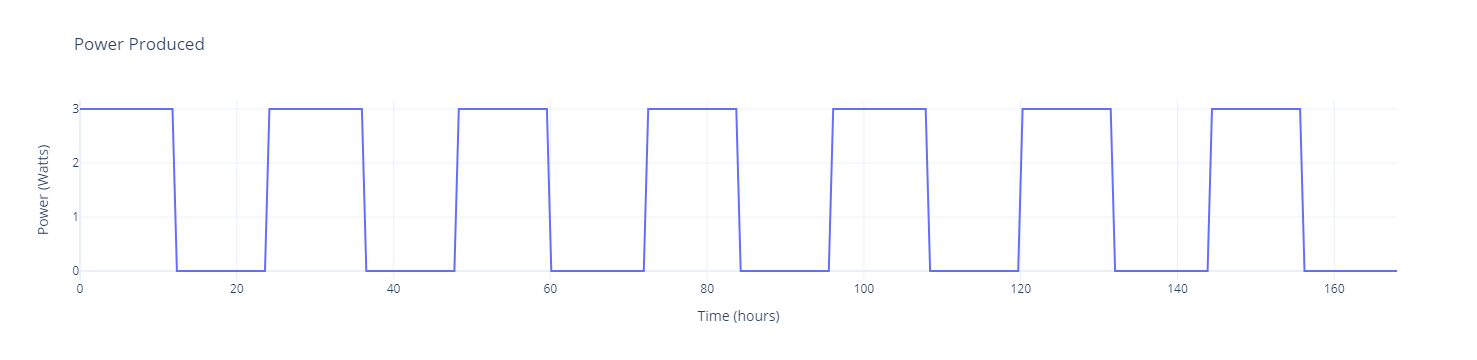

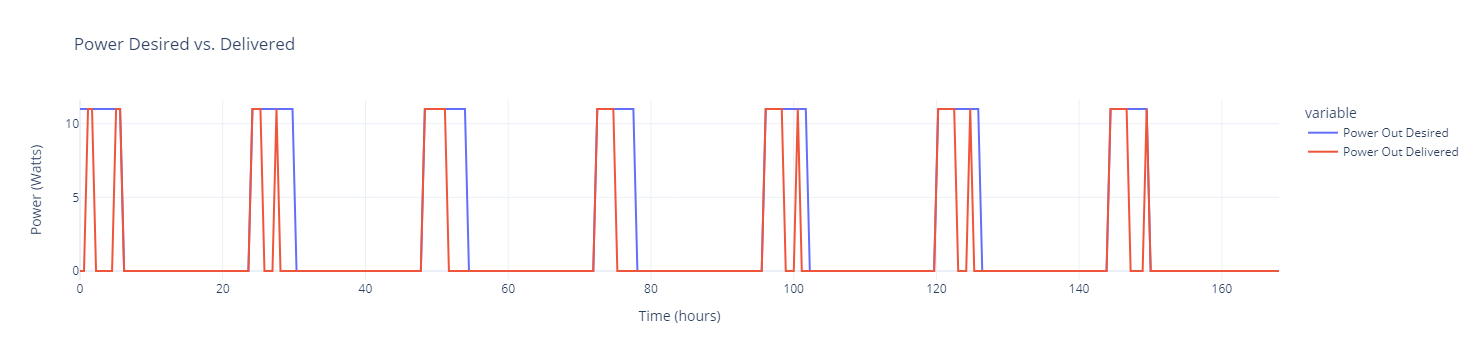

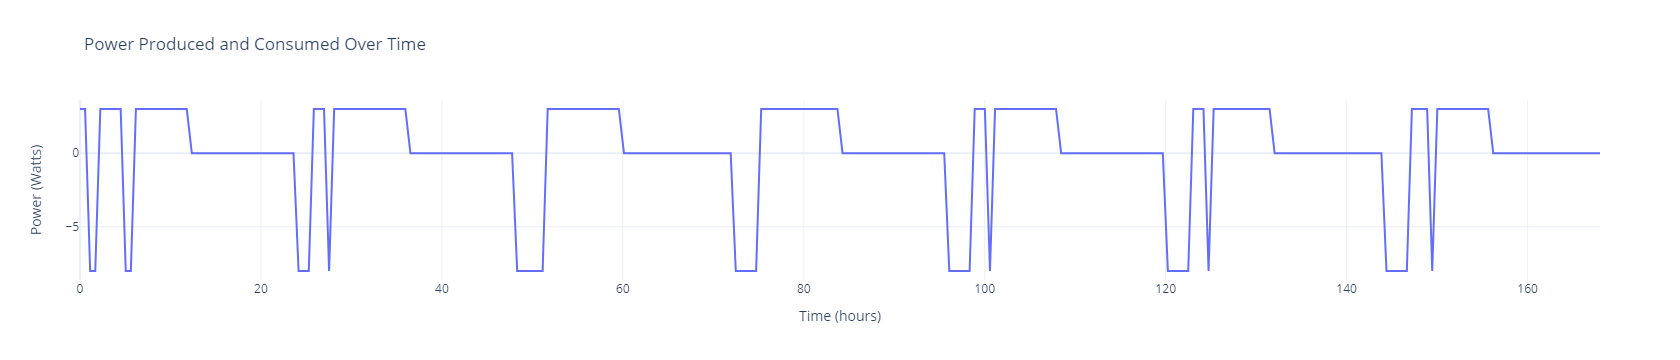

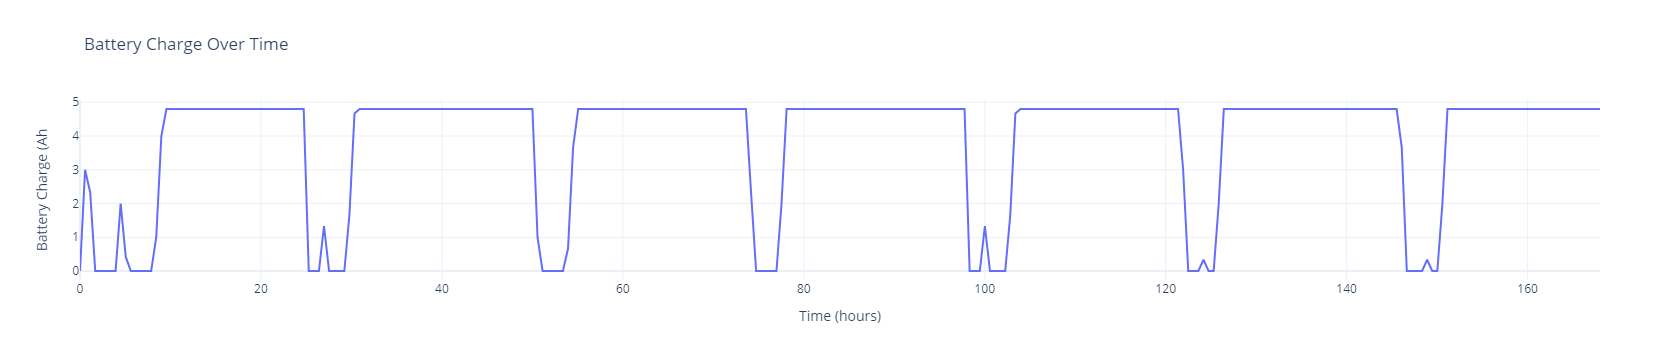

Kendall's Tau: 0.6496562413608934
P-value: 2.788587401674681e-29


# Study Configuration 2

 $$PanelCount =  2 $$

 $$BatteryCount =  3 $$

 $$BatteryCapacity = BatteryCapactiy * BatteryCount = 2.8 * 3 AH $$

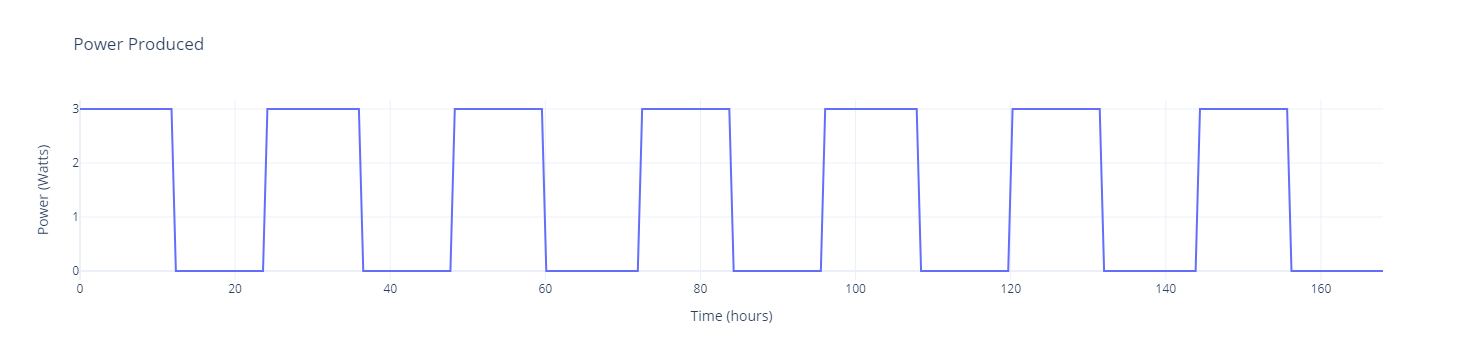

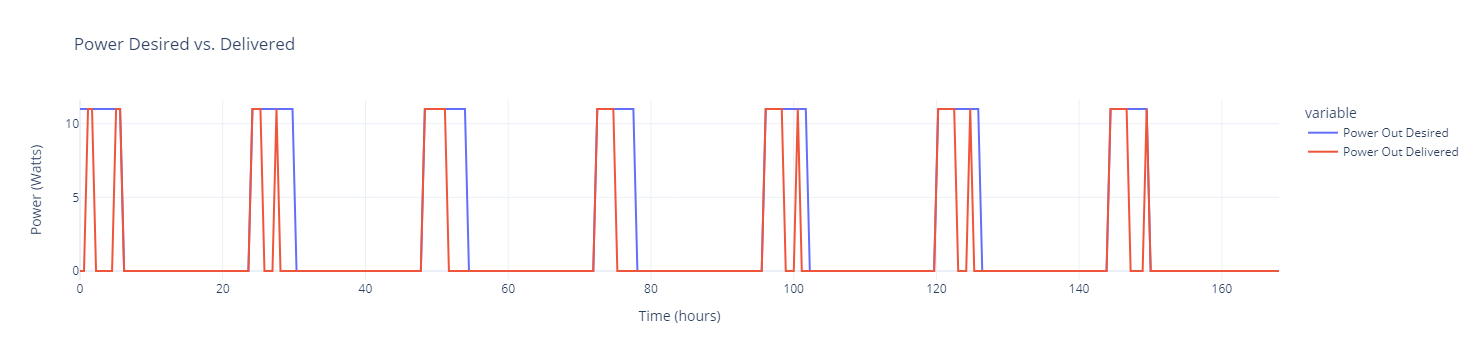

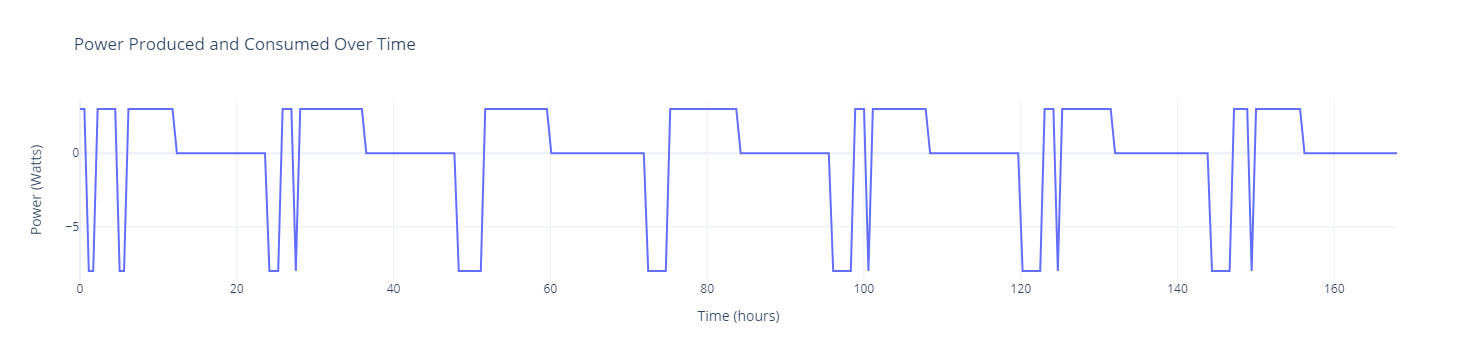

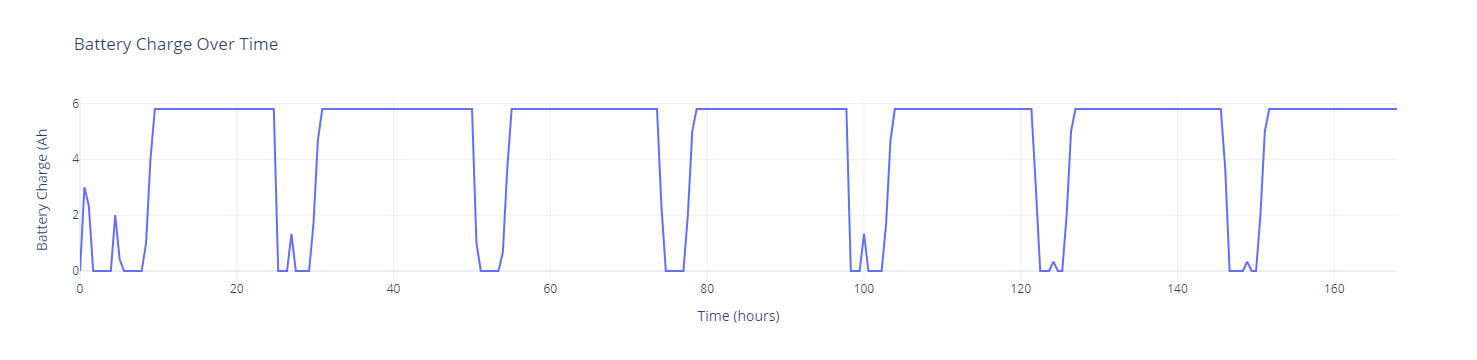

Kendall's Tau: 0.6496562413608934
P-value: 2.788587401674681e-29


# Study Configuration 3

 $$PanelCount =  2 $$

 $$BatteryCount =  4 $$

 $$BatteryCapacity = BatteryCapactiy * BatteryCount = 2.8 * 4 AH $$

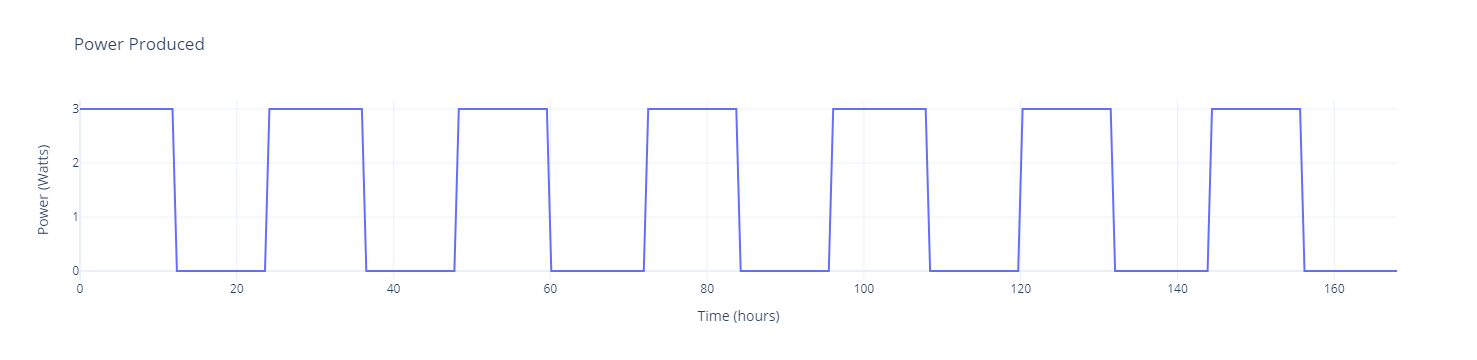

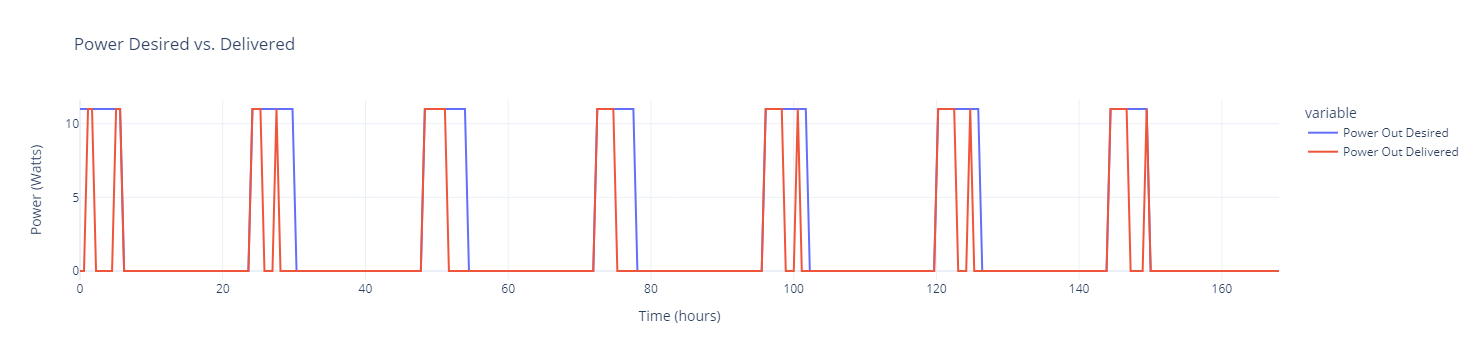

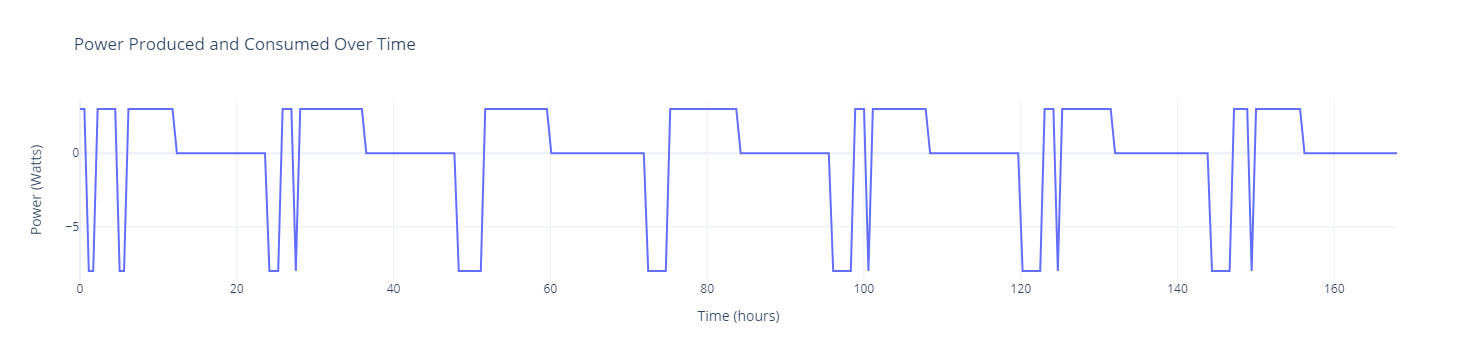

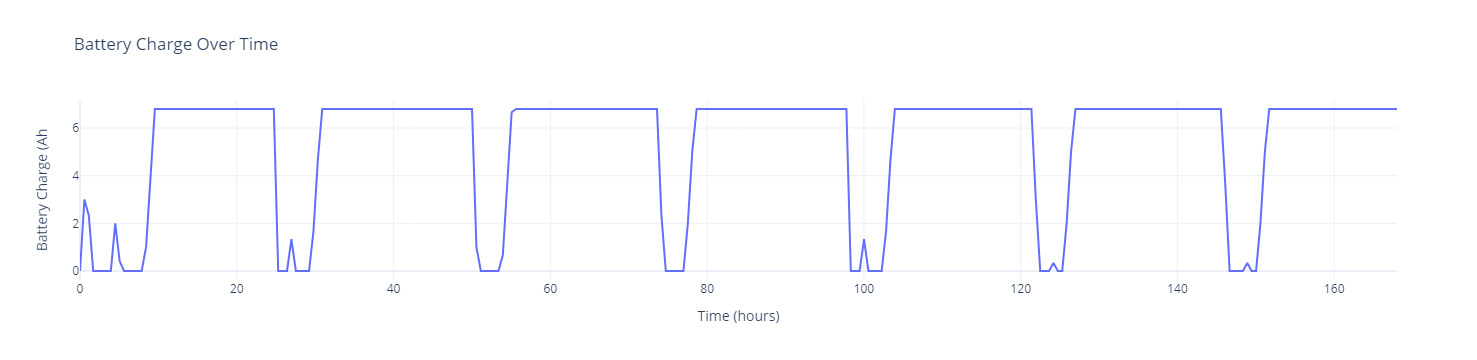

Kendall's Tau: 0.6496562413608934
P-value: 2.788587401674681e-29


# Study Configuration 4

 $$PanelCount =  3 $$

 $$BatteryCount =  2 $$

 $$BatteryCapacity = BatteryCapactiy * BatteryCount = 2.8 * 2 AH $$

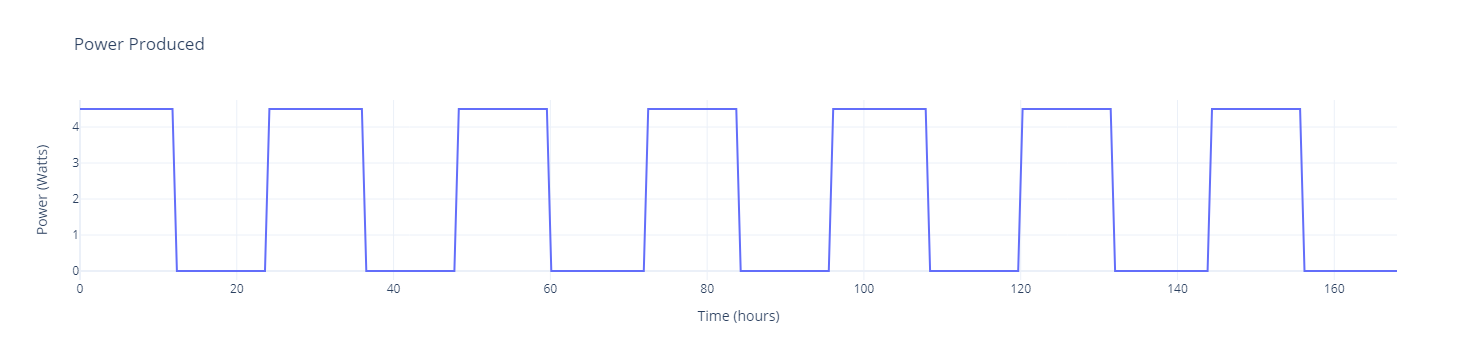

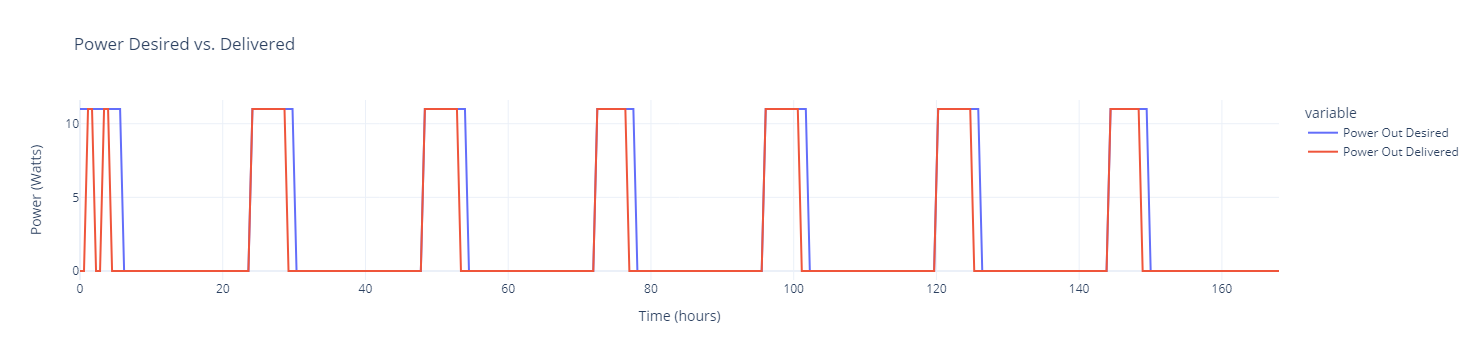

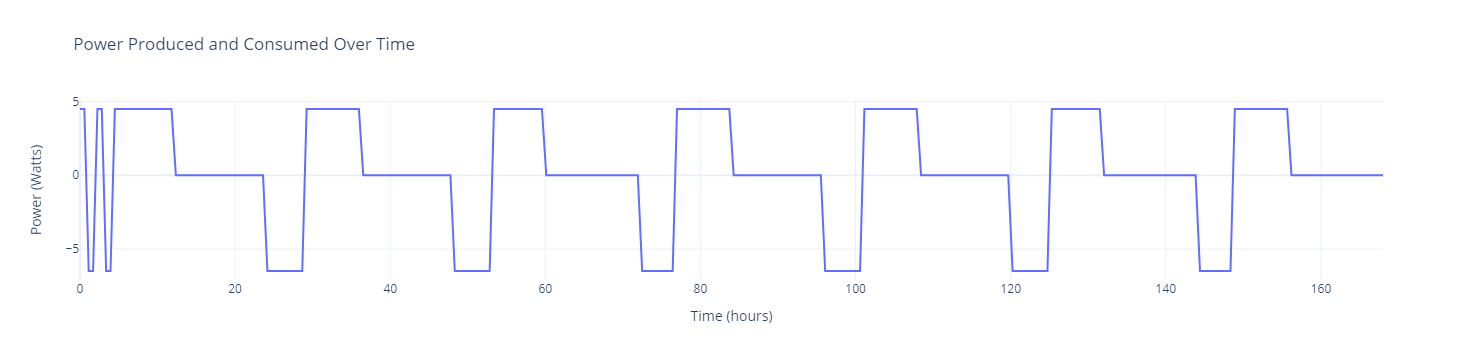

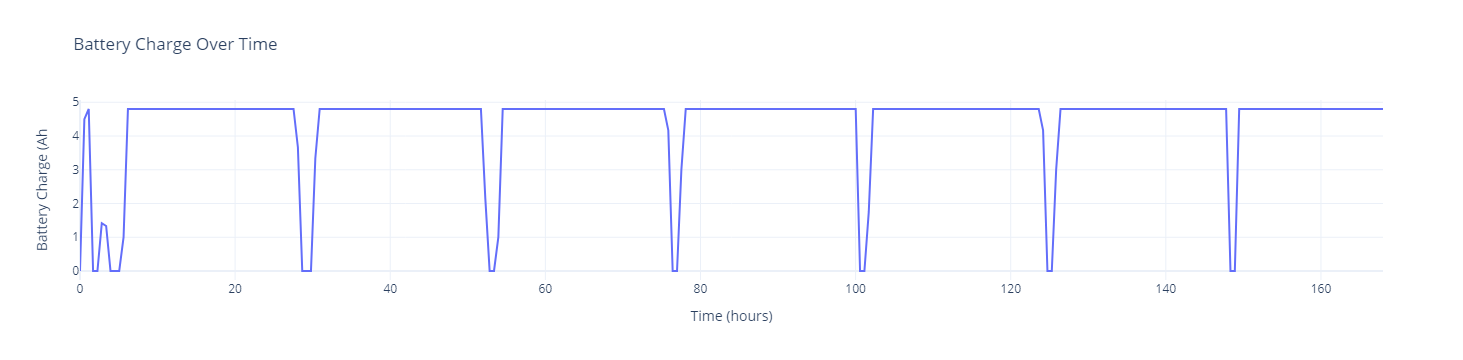

Kendall's Tau: 0.8297738186782796
P-value: 1.094477621300331e-46


# Study Configuration 5

 $$PanelCount =  3 $$

 $$BatteryCount =  3 $$

 $$BatteryCapacity = BatteryCapactiy * BatteryCount = 2.8 * 3 AH $$

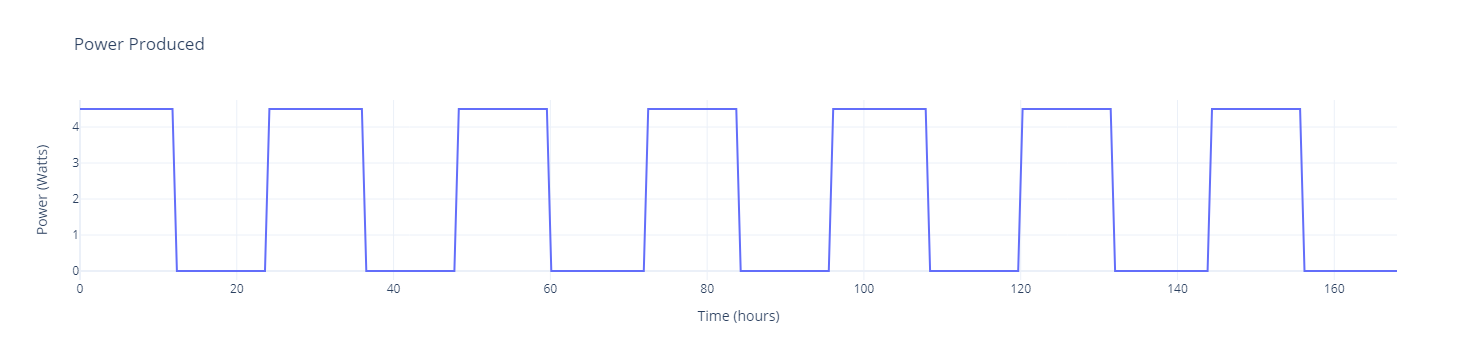

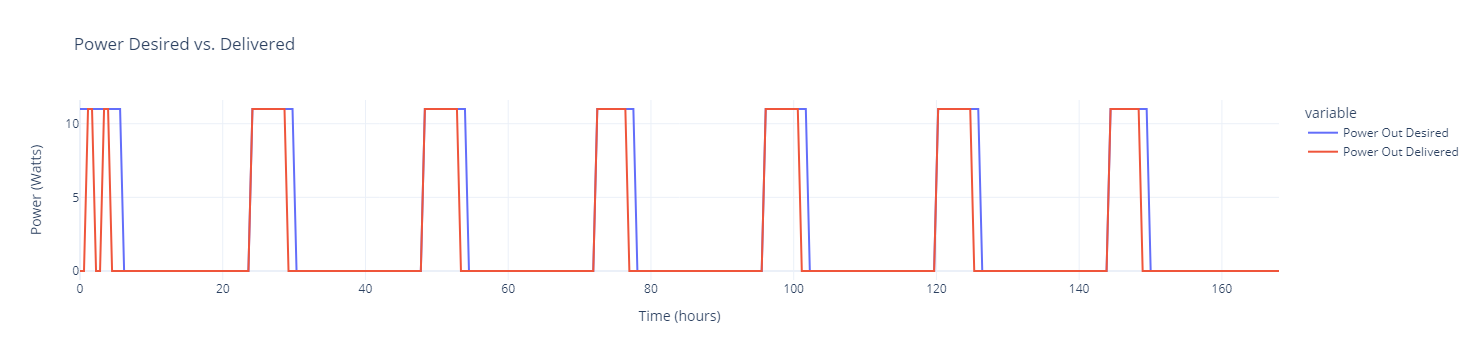

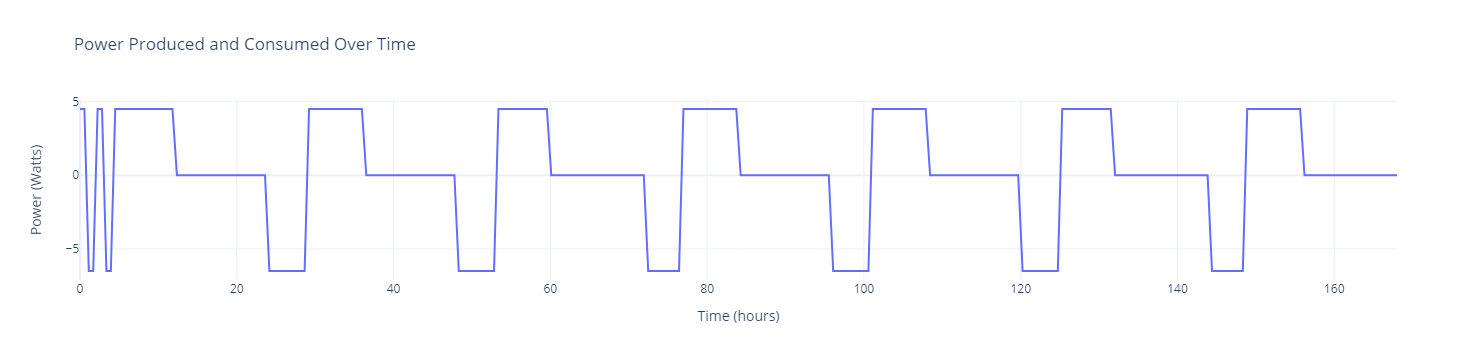

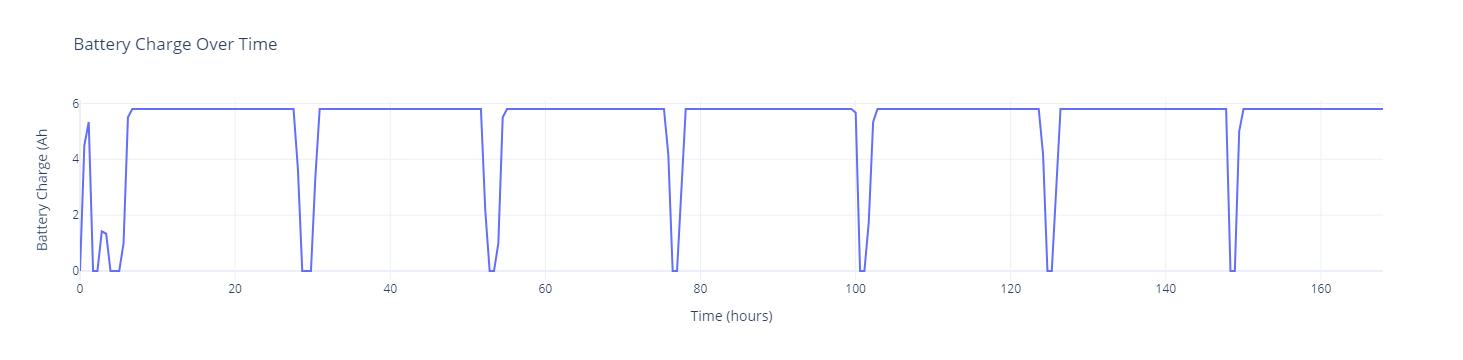

Kendall's Tau: 0.8297738186782796
P-value: 1.094477621300331e-46


# Study Configuration 6

 $$PanelCount =  3 $$

 $$BatteryCount =  4 $$

 $$BatteryCapacity = BatteryCapactiy * BatteryCount = 2.8 * 4 AH $$

Kendall's Tau: 0.8297738186782796
P-value: 1.094477621300331e-46


# Study Configuration 7

 $$PanelCount =  4 $$

 $$BatteryCount =  2 $$

 $$BatteryCapacity = BatteryCapactiy * BatteryCount = 2.8 * 2 AH $$

Kendall's Tau: 0.9555330859059091
P-value: 2.5181723285189077e-61


# Study Configuration 8

 $$PanelCount =  4 $$

 $$BatteryCount =  3 $$

 $$BatteryCapacity = BatteryCapactiy * BatteryCount = 2.8 * 3 AH $$

Kendall's Tau: 0.9555330859059091
P-value: 2.5181723285189077e-61


# Study Configuration 9

 This is the highest cost option. It has the hightest amount of solar panels and batterys.

 $$PanelCount =  4 $$

 $$BatteryCount =  4 $$

 $$BatteryCapacity = BatteryCapactiy * BatteryCount = 2.8 * 4 AH $$

Kendall's Tau: 0.9555330859059091
P-value: 2.5181723285189077e-61


In [11]:


panel_count = solar_panel_count_min 
study = 1
while panel_count <= solar_panel_count_max :
    #print("panel_count",panel_count)
    battery_count = battery_count_min
    while battery_count <= battery_count_max:
        #print("battery_count",battery_count)
        display(Markdown(f"# Study Configuration {study}"))
        if study == 1:
            display(Markdown(f" This is low cost option. It has the least amount of solar panels and batterys."))
        if study == 9:
            display(Markdown(f" This is the highest cost option. It has the hightest amount of solar panels and batterys.")) 
        display(Markdown(f" $$PanelCount =  {panel_count} $$"))
        display(Markdown(f" $$BatteryCount =  {battery_count} $$"))
        
        display(Markdown(f" $$BatteryCapacity = BatteryCapactiy * BatteryCount = { battery_capacity } * {battery_count} AH $$"))

        power_in_expr = power_generator(t, sun_period_value * 24/100, 24, 7*24,  panel_power*panel_count ,charger_eff)
        power_out_expr = battery_load(t , load_period_value*  24/100,  24,  7*24  ,boost_current_limit,boost_efficiency)
        #power_expr = power_in_expr -   power_out_expr
        #print(simplify(power_expr))

        
        # Substitute period value into the expression
        power_in_func = power_in_expr.subs(period, sun_period_value)
        power_out_func = power_out_expr.subs(period, sun_period_value)
        #power_func = power_expr.subs(period, sun_period_value)

        
        
        # Generate data for plotting
        t_vals = np.linspace(0, 7*24, 300)
        total_powers = []
        battery_powers =[]
        power_in = []
        power_out_desired = []
        power_out_delivered = []
        t_val_points = []
        battery_power =0 
        for t_val in t_vals:
            power_in_eval = power_in_func.evalf(subs={t: t_val})
            power_out_eval = power_out_func.evalf(subs={t: t_val})
            

            t_val_points.append(t_val)# for simpson
            power_in.append(float(power_in_eval))
            power_out_desired.append(float(power_out_eval))
            if battery_power <= 0 :
                power_out_delivered.append(float(0.0))
                total_powers.append(float(power_in_eval )) #had to covert to python float to elimnate TypeError: float() argument must be a string or a real number, not 'generator'
            else :
                power_out_delivered.append(float(power_out_eval))
                total_powers.append(float(power_in_eval - power_out_eval)) #had to covert to python float to elimnate TypeError: float() argument must be a string or a real number, not 'generator'
            battery_power= simpson( total_powers)
            if battery_power >= battery_capacity + battery_count :
                battery_power = battery_capacity + battery_count
            if battery_power <  0  :
                battery_power = 0
            battery_powers.append(float(battery_power)) #had to covert to python float to elimnate TypeError: float() argument must be a string or a real number, not 'generator'
        #print(f"Numerical Integration Result: {battery_power}")
        #print(f"Estimated Error: {error}")
        study =  study +1

        
        df = pd.DataFrame({'Time': t_vals,'Power In': power_in,'Power Out Desired':power_out_desired,'Power Out Delivered':power_out_delivered, 'Power':total_powers,'Battery Power':battery_powers})
        #print(df)
        fig = px.line(df, x='Time', y='Power In', title='Power Produced')
        
        fig.update_layout(xaxis_title='Time (hours)',
                           yaxis_title='Power (Watts)')
        # Show the plot
        fig.show()
 
        fig = px.line(df, x='Time',  y=[ 'Power Out Desired','Power Out Delivered'], title='Power Desired vs. Delivered')
        
        fig.update_layout(xaxis_title='Time (hours)',
                           yaxis_title='Power (Watts)')
        # Show the plot
        fig.show()

        
        fig = px.line(df, x='Time', y='Power', title='Power Produced and Consumed Over Time')
        
        fig.update_layout(xaxis_title='Time (hours)',
                           yaxis_title='Power (Watts)')
        # Show the plot
        fig.show()
        
        
        fig = px.line(df, x='Time', y='Battery Power', title='Battery Charge Over Time')
        
        fig.update_layout(xaxis_title='Time (hours)',
                           yaxis_title='Battery Charge (Ah')
        # Show the plot
        fig.show()   
        correlation,p_value  = kendalltau(df['Power Out Desired'],df['Power Out Delivered'])
        print(f"Kendall's Tau: {correlation}")
        print(f"P-value: {p_value}")
        battery_count = 1 + battery_count
    panel_count = 1 + panel_count
     


## Study Summary (Manual Update by Study Reviewer) 
Study results indicates that a good solution for the maximum desired use, that 4 solar panels and at least 3 batteries will meet the deired need. 